In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-10 13:07:53.849070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(i) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/D-25/Device-25(i)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.046875 -0.0546875j  0.0703125+0.0078125j -0.015625 -0.078125j  ...
 -0.0390625-0.1640625j -0.078125 -0.0234375j  0.0234375-0.0078125j]
2048
75193
(2048, 75193)
[0.02891908 0.01625739 0.00515618 ... 0.00561692 0.00572858 0.01698964]
0
(10000, 2048)
(10000,)
[ 0.046875 +0.0078125j -0.0859375+0.015625j   0.078125 -0.03125j   ...
  0.09375  -0.015625j  -0.015625 -0.0625j    -0.0234375-0.0859375j]
2048
71536
(2048, 71536)
[0.02900774 0.01949993 0.00782374 ... 0.0054048  0.0065753  0.01679224]
1
(20000, 2048)
(20000,)
[-0.015625 -0.0390625j  0.046875 -0.046875j   0.0078125+0.015625j  ...
  0.       +0.0078125j -0.0078125-0.0546875j -0.0390625-0.03125j  ]
2048
79948
(2048, 79948)
[0.02881636 0.01655435 0.00561349 ... 0.00583372 0.00589733 0.01669759]
2
(30000, 2048)
(30000,)
[ 0.0546875+0.046875j  -0.015625 -0.0078125j  0.0625   -0.015625j  ...
 -0.0234375-0.125j      0.0546875+0.046875j   0.       -0.0546875j]
2048
85725
(2048, 85725)
[0.0291865  0.01664384 0.00656994 ... 0.00673976 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(ii) model to Nordic Device-25(i) dataset 

In [7]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [8]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.4628 - accuracy: 0.8220
test loss, test acc: [0.4627801775932312, 0.8220250010490417]


In [9]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[0 0 0 ... 7 7 7]
0
[[9154    0  594    0  110  139    0    3]
 [   1 9953    9    0    0   31    6    0]
 [   9    1 6722    0    0 2181 1084    3]
 [   0    0   62 9849    0    0   89    0]
 [ 207    0  282    0 6995 2506    0   10]
 [1486   43 3579    4    0 4511  360   17]
 [   4    1   74    2    0   70 9848    1]
 [  62  346   34    0    0  675  153 8730]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     10000
           1       0.96      1.00      0.98     10000
           2       0.59      0.67      0.63     10000
           3       1.00      0.98      0.99     10000
           4       0.98      0.70      0.82     10000
           5       0.45      0.45      0.45     10000
           6       0.85      0.98      0.91     10000
           7       1.00      0.87      0.93     10000

    accuracy                           0.82     80000
   macro avg       0.83      0.82   

Test Accuracy:0.822025


Text(0.5, 1.0, 'Accuracy:0.822')

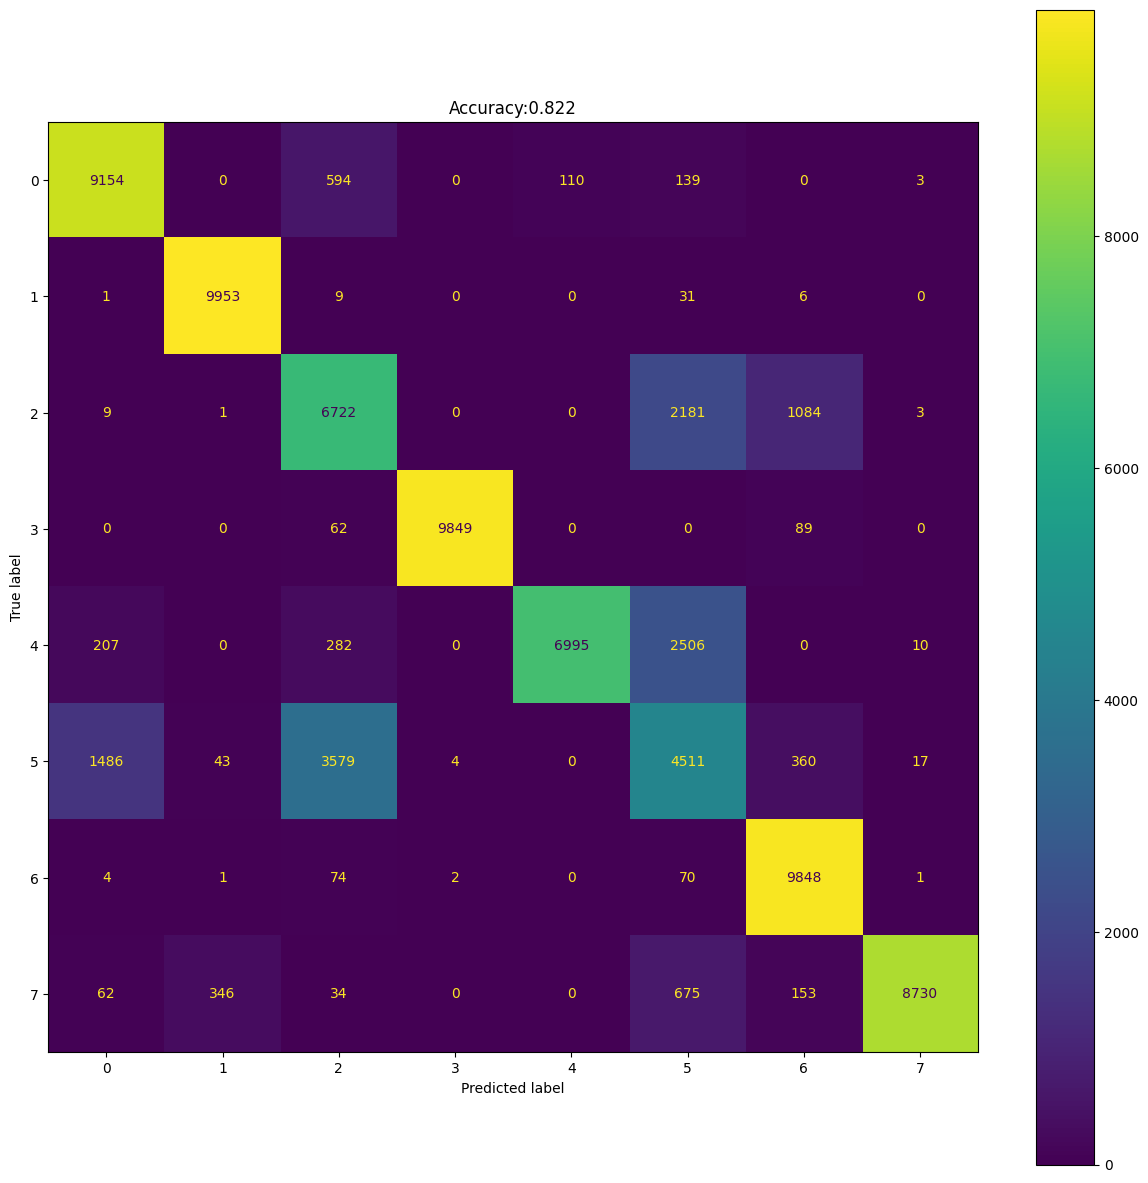

In [11]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(ii) model to Nordic Device-25(i) dataset 

In [12]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [13]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [14]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 4ms/step - loss: 0.3086 - accuracy: 0.8860
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2341 - accuracy: 0.9162
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2027 - accuracy: 0.9299
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1862 - accuracy: 0.9364
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1766 - accuracy: 0.9407
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.1706 - accuracy: 0.9433
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1664 - accuracy: 0.9454
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.1633 - accuracy: 0.9467
Epoch 9/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.1610 - accuracy: 0.9476
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - lo

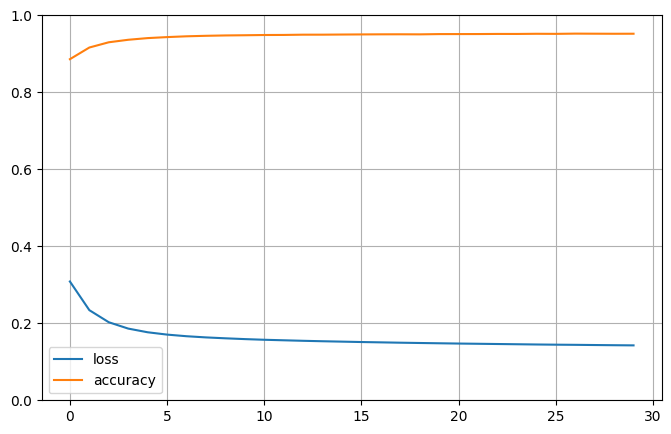

In [15]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1422 - accuracy: 0.9525
test loss, test acc: [0.14215070009231567, 0.9524875283241272]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[9531    0    0    0  199  266    0    4]
 [   0 9949   26    0    0   23    0    2]
 [   1    0 8748    3   11 1035  169   33]
 [   0    0    2 9946    0    0   52    0]
 [ 248    0   16    0 9652   82    0    2]
 [ 293    1  809    5   47 8786    7   52]
 [   4    0  162    7    0   15 9795   17]
 [   2    1   78    0   35   90    2 9792]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       1.00      0.99      1.00     10000
           2       0.89      0.87      0.88     10000
           3       1.00      0.99      1.00     10000
           4       0.97      0.97      0.97     10000
           5       0.85      0.88      0.87     10000
           6       0.98      0.98      0.98     10000
           7       0.99      0.98      0.98     10000

    accuracy                           0.95     80000
   macro avg       0.95      0.95  

Test Accuracy:0.9524875


Text(0.5, 1.0, 'Accuracy:0.952')

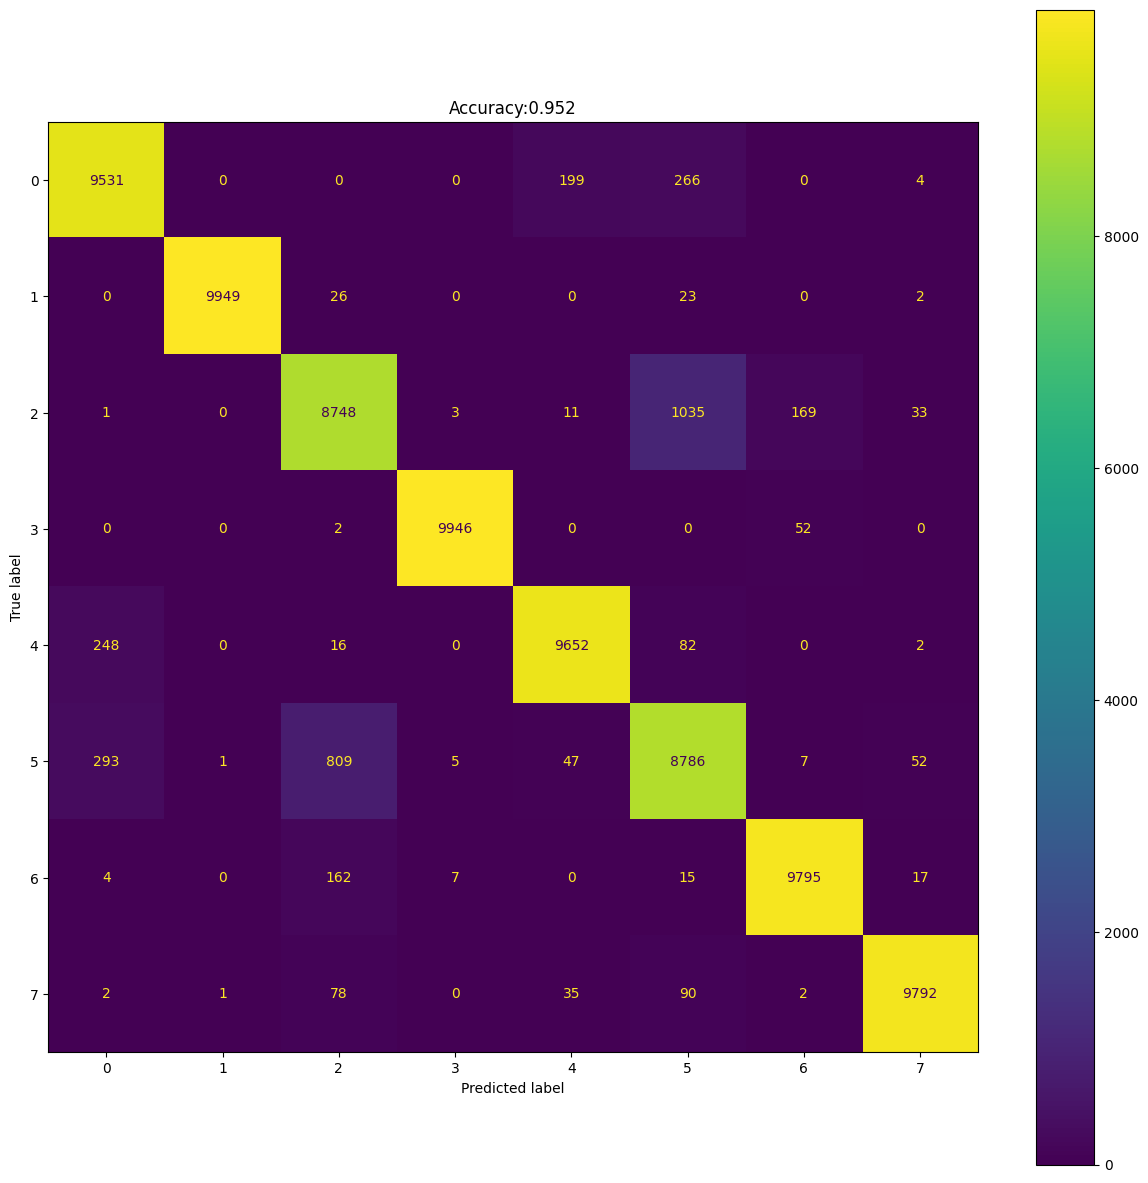

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-25(i) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

2023-04-10 13:29:30.913627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 4.5871 - accuracy: 0.1348
test loss, test acc: [4.587141513824463, 0.13481250405311584]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[3 5 5 ... 7 4 2]
3
[[ 484  122 1653  248  195 6696  481  121]
 [ 341   20 6297 1852  432  335  311  412]
 [ 457  111 2670  299  469 5354  495  145]
 [ 376   67 3323  179  265 4976  496  318]
 [ 485  209 1540  316  315 6407  631   97]
 [ 193  103 1728  311  423 6499  457  286]
 [ 107  170 1969  422  446 6226  305  355]
 [ 948   94 1244  401 1966 4679  355  313]]
              precision    recall  f1-score   support

           0       0.14      0.05      0.07     10000
           1       0.02      0.00      0.00     10000
           2       0.13      0.27      0.18     10000
           3       0.04      0.02      0.03     10000
           4       0.07      0.03      0.04     10000
           5       0.16      0.65      0.25     10000
           6       0.09      0.03      0.05     10000
           7       0.15      0.03      0.05     10000

    accuracy                           0.13     80000
   macro avg       0.10      0.13   

Test Accuracy:0.1348125


Text(0.5, 1.0, 'Accuracy:0.135')

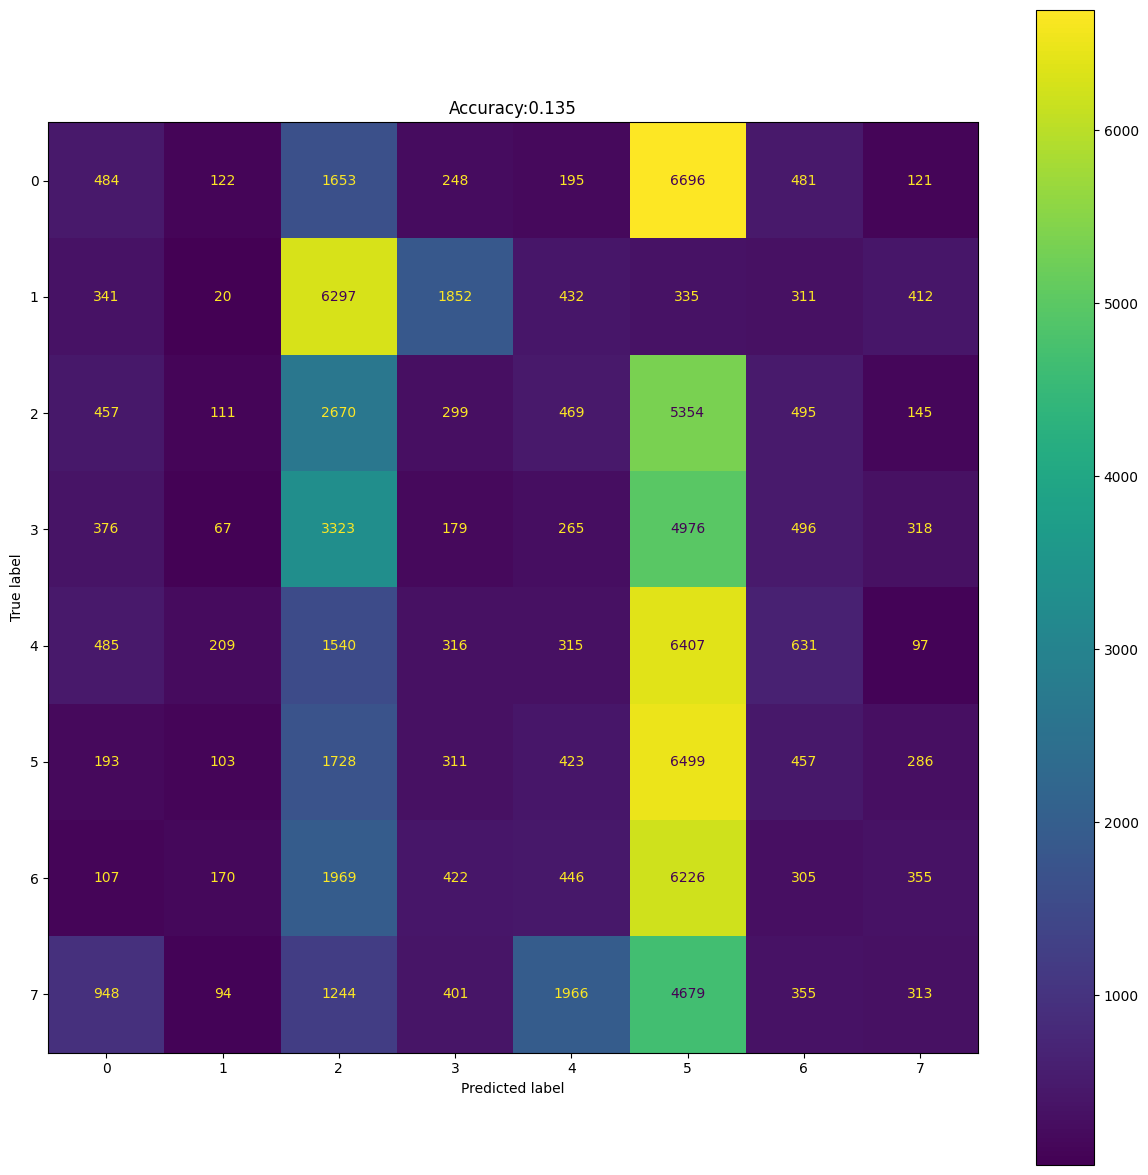

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iii) model to Nordic Device-25(i) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 3.1265 - accuracy: 0.1394
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.1086 - accuracy: 0.2395
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8033 - accuracy: 0.3153
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6961 - accuracy: 0.3670
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6401 - accuracy: 0.3947
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6024 - accuracy: 0.4133
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5740 - accuracy: 0.4284
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5509 - accuracy: 0.4400
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5309 - accuracy: 0.4494
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

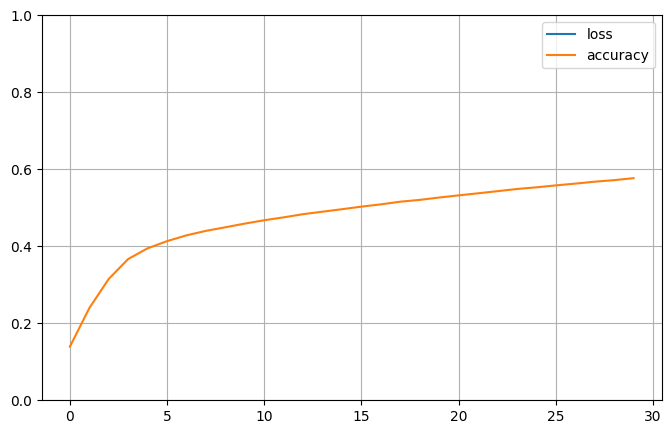

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.2922 - accuracy: 0.5797
test loss, test acc: [1.292156457901001, 0.5796999931335449]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 0 0 ... 5 7 2]
7
[[5253  189  776  482 1235 1184  305  576]
 [  34 9461   61   11   93   23  128  189]
 [1381  391 3338 1069 1289 1271  455  806]
 [ 215   96  359 8051  220  223  601  235]
 [1292  237  787  464 5229  952  284  755]
 [1635  242 1150  814 1097 3702  481  879]
 [ 906  287  587 1147  766  643 4736  928]
 [ 650  607  256  342  498  657  384 6606]]
              precision    recall  f1-score   support

           0       0.46      0.53      0.49     10000
           1       0.82      0.95      0.88     10000
           2       0.46      0.33      0.39     10000
           3       0.65      0.81      0.72     10000
           4       0.50      0.52      0.51     10000
           5       0.43      0.37      0.40     10000
           6       0.64      0.47      0.55     10000
           7       0.60      0.66      0.63     10000

    accuracy                           0.58     80000
   macro avg       0.57      0.58  

Test Accuracy:0.5797


Text(0.5, 1.0, 'Accuracy:0.580')

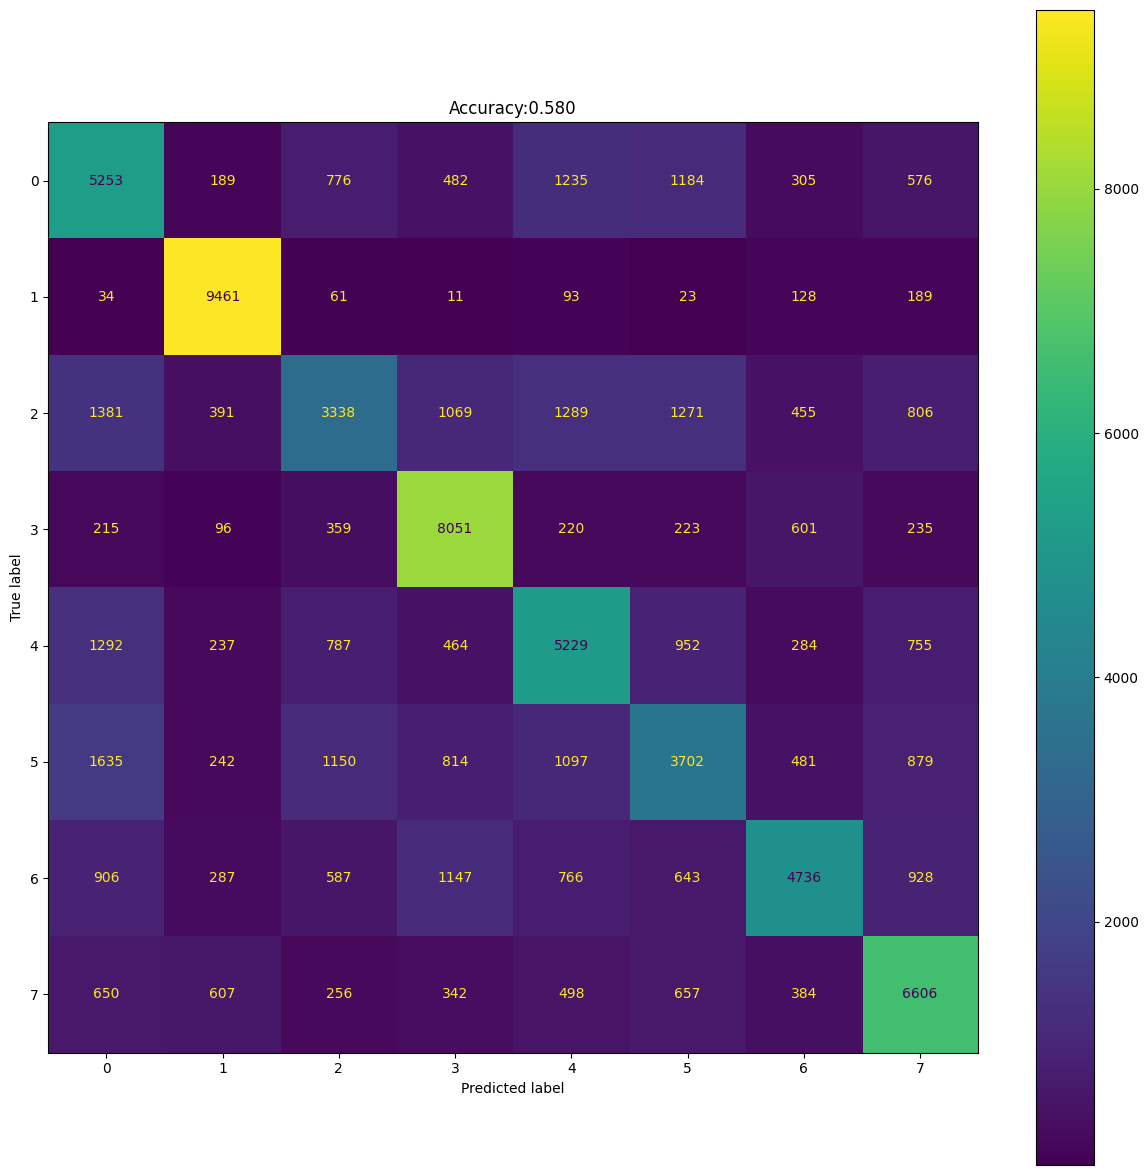

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-25(i) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 5ms/step - loss: 4.6284 - accuracy: 0.1384
test loss, test acc: [4.628434658050537, 0.13842499256134033]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 5 0 ... 7 0 0]
5
[[1463   23  667  115  472 6831  266  163]
 [3809    0   64  638 1371 2299 1009  810]
 [1181   25 1029   76  820 6439  269  161]
 [1282   53 4572  475  131 3062  252  173]
 [1351   61 1176   96  826 5734  598  158]
 [1538   10  651   60  724 6335  350  332]
 [1007   12 2095   84  274 5359  527  642]
 [3574    6   75  117 1679 3004 1126  419]]
              precision    recall  f1-score   support

           0       0.10      0.15      0.12     10000
           1       0.00      0.00      0.00     10000
           2       0.10      0.10      0.10     10000
           3       0.29      0.05      0.08     10000
           4       0.13      0.08      0.10     10000
           5       0.16      0.63      0.26     10000
           6       0.12      0.05      0.07     10000
           7       0.15      0.04      0.07     10000

    accuracy                           0.14     80000
   macro avg       0.13      0.14  

Test Accuracy:0.138425


Text(0.5, 1.0, 'Accuracy:0.138')

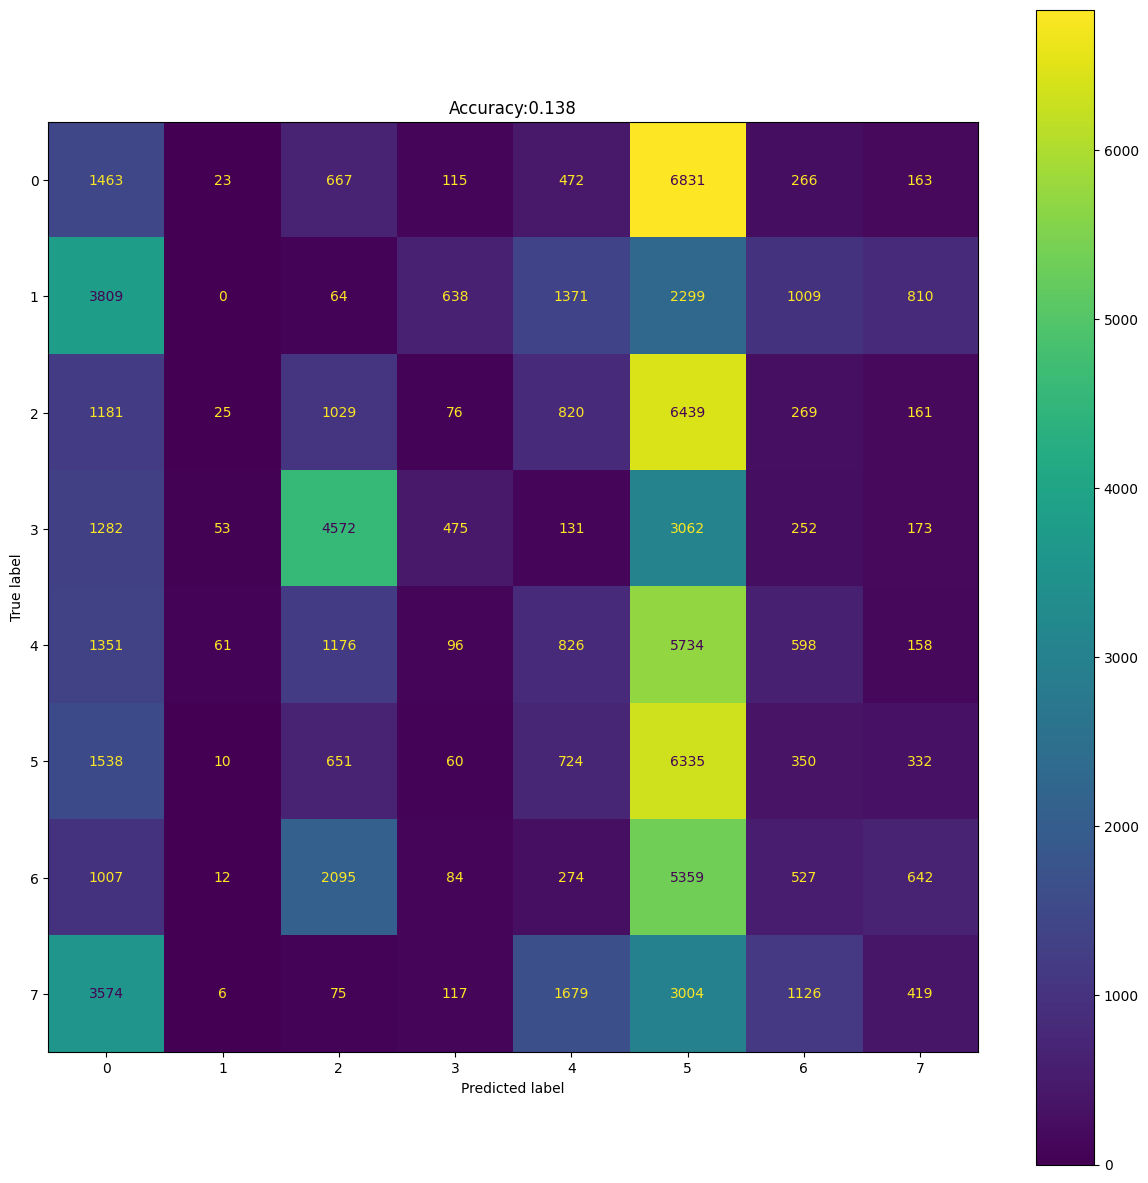

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 4ms/step - loss: 2.9878 - accuracy: 0.1758
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9633 - accuracy: 0.2668
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6957 - accuracy: 0.3573
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5999 - accuracy: 0.4027
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5543 - accuracy: 0.4220
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5262 - accuracy: 0.4345
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5056 - accuracy: 0.4442
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4885 - accuracy: 0.4517
Epoch 9/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.4741 - accuracy: 0.4582
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

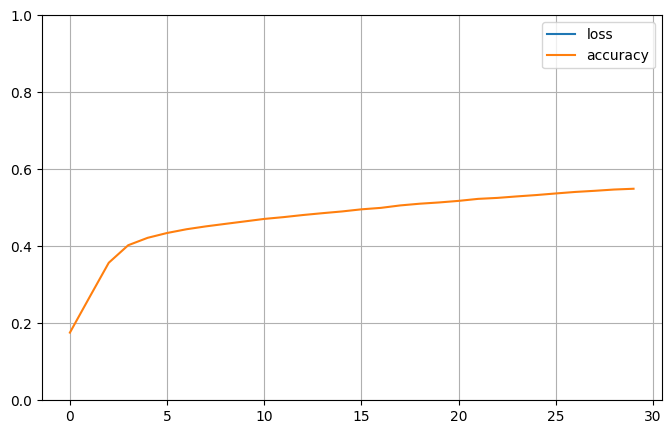

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2876 - accuracy: 0.5522
test loss, test acc: [1.2875709533691406, 0.552174985408783]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[4 0 4 ... 1 1 2]
4
[[3648  178  944  840 2130 1258  360  642]
 [ 104 9151   93  111   34   24  211  272]
 [1150   90 3153  934 1854 1490  676  653]
 [ 295  115  530 7422  464  155  957   62]
 [1011  121  831  860 5255  646  481  795]
 [1439  209 1477  634 1373 3287  693  888]
 [ 332  263 1040 1584  589  636 5225  331]
 [ 241  948  313   96  661  357  351 7033]]
              precision    recall  f1-score   support

           0       0.44      0.36      0.40     10000
           1       0.83      0.92      0.87     10000
           2       0.38      0.32      0.34     10000
           3       0.59      0.74      0.66     10000
           4       0.43      0.53      0.47     10000
           5       0.42      0.33      0.37     10000
           6       0.58      0.52      0.55     10000
           7       0.66      0.70      0.68     10000

    accuracy                           0.55     80000
   macro avg       0.54      0.55   

Test Accuracy:0.552175


Text(0.5, 1.0, 'Accuracy:0.552')

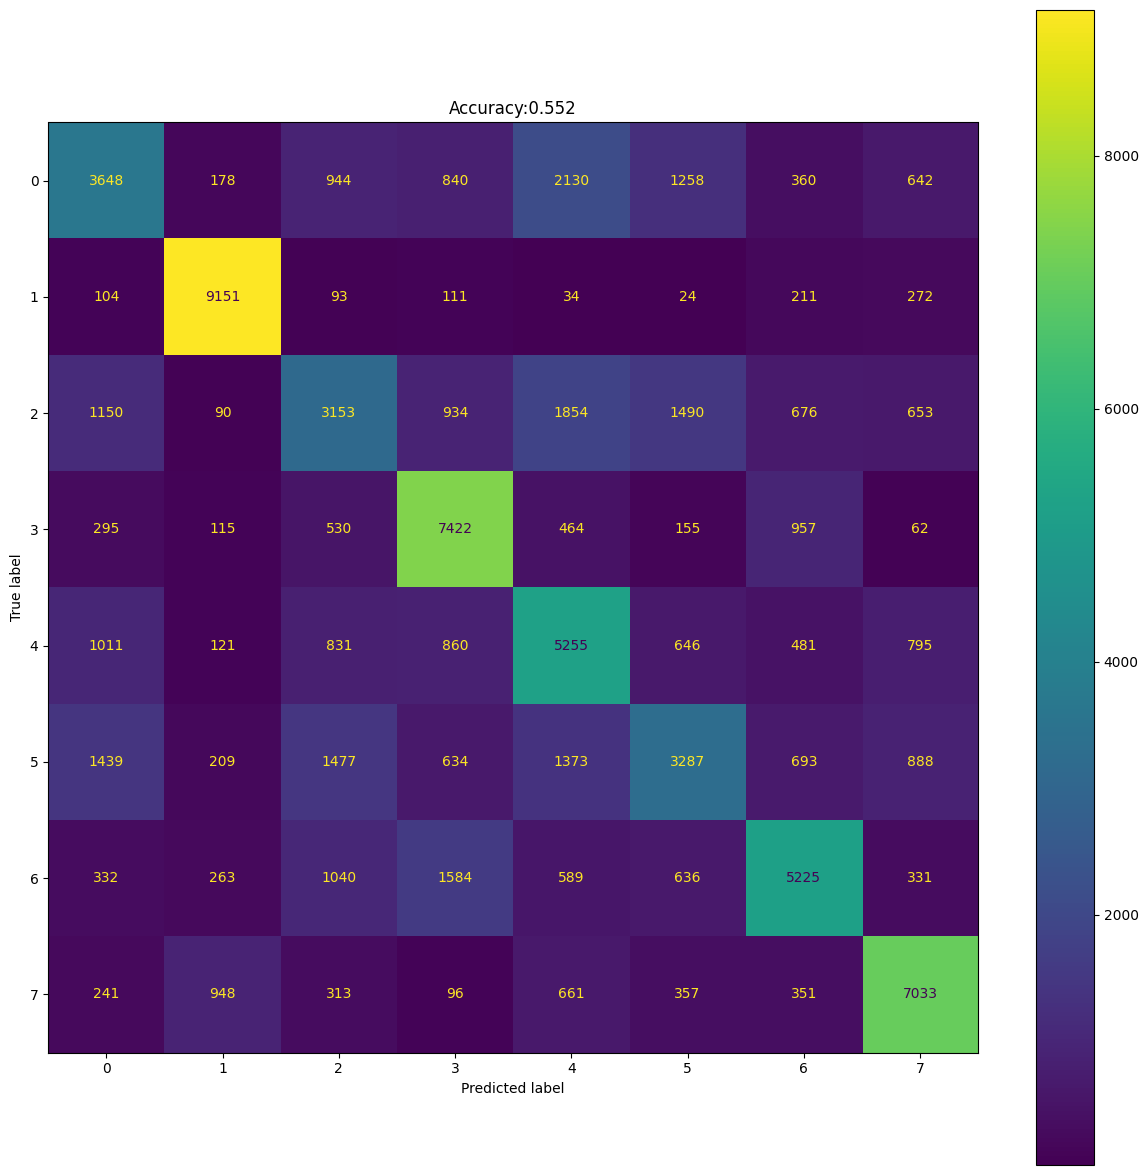

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-25(i) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 5.4791 - accuracy: 0.1291
test loss, test acc: [5.479125022888184, 0.12908749282360077]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 5 4 ... 5 0 0]
5
[[ 132   14  789  182  515 8300   30   38]
 [ 266  281 2716 1444 2761 2136  136  260]
 [ 275    3 1140  265  563 7723   13   18]
 [ 316   11 3308  299  488 5485   70   23]
 [ 148   33  650  181  294 8627   29   38]
 [ 144    1  626  201  766 8159   31   72]
 [ 344    8 1249  695 1024 6577    9   94]
 [1175   18 1415  549 1848 4776  206   13]]
              precision    recall  f1-score   support

           0       0.05      0.01      0.02     10000
           1       0.76      0.03      0.05     10000
           2       0.10      0.11      0.10     10000
           3       0.08      0.03      0.04     10000
           4       0.04      0.03      0.03     10000
           5       0.16      0.82      0.26     10000
           6       0.02      0.00      0.00     10000
           7       0.02      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.15      0.13  

Test Accuracy:0.1290875


Text(0.5, 1.0, 'Accuracy:0.129')

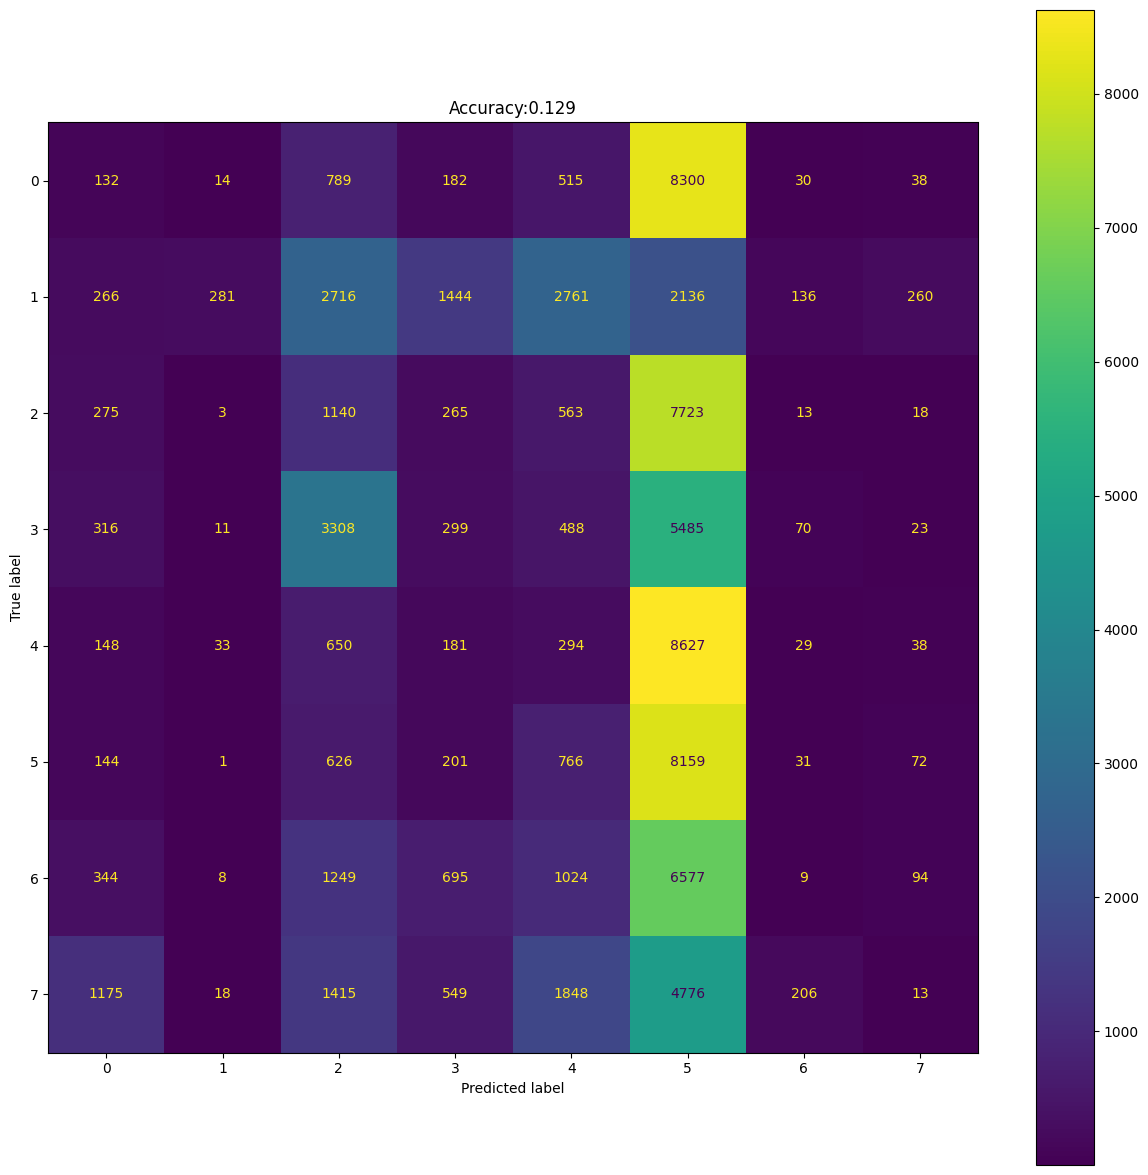

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-25(i) dataset 

In [30]:
model = keras.models.load_model("//Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 3.1653 - accuracy: 0.1272
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0260 - accuracy: 0.2311
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7891 - accuracy: 0.3090
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7101 - accuracy: 0.3471
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6667 - accuracy: 0.3699
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6358 - accuracy: 0.3853
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6111 - accuracy: 0.3985
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5901 - accuracy: 0.4088
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5709 - accuracy: 0.4194
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

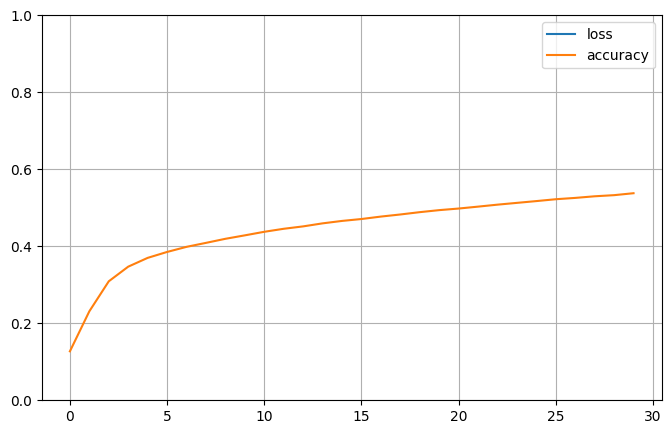

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.3438 - accuracy: 0.5370
test loss, test acc: [1.3437713384628296, 0.537024974822998]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[1 4 0 ... 6 7 7]
1
[[2924  215  847 1279 2147 1269  615  704]
 [  34 9067   15  133   96   74  331  250]
 [ 638  150 2419 1738 1605 1458  892 1100]
 [ 329  427  246 6957  411  426  769  435]
 [ 541  194  804  745 5789  853  399  675]
 [ 862  237  973 1263 1173 3759  910  823]
 [ 336  379  325 1052  500  561 6012  835]
 [ 218  707  371 1129  490  372  678 6035]]
              precision    recall  f1-score   support

           0       0.50      0.29      0.37     10000
           1       0.80      0.91      0.85     10000
           2       0.40      0.24      0.30     10000
           3       0.49      0.70      0.57     10000
           4       0.47      0.58      0.52     10000
           5       0.43      0.38      0.40     10000
           6       0.57      0.60      0.58     10000
           7       0.56      0.60      0.58     10000

    accuracy                           0.54     80000
   macro avg       0.53      0.54  

Test Accuracy:0.537025


Text(0.5, 1.0, 'Accuracy:0.537')

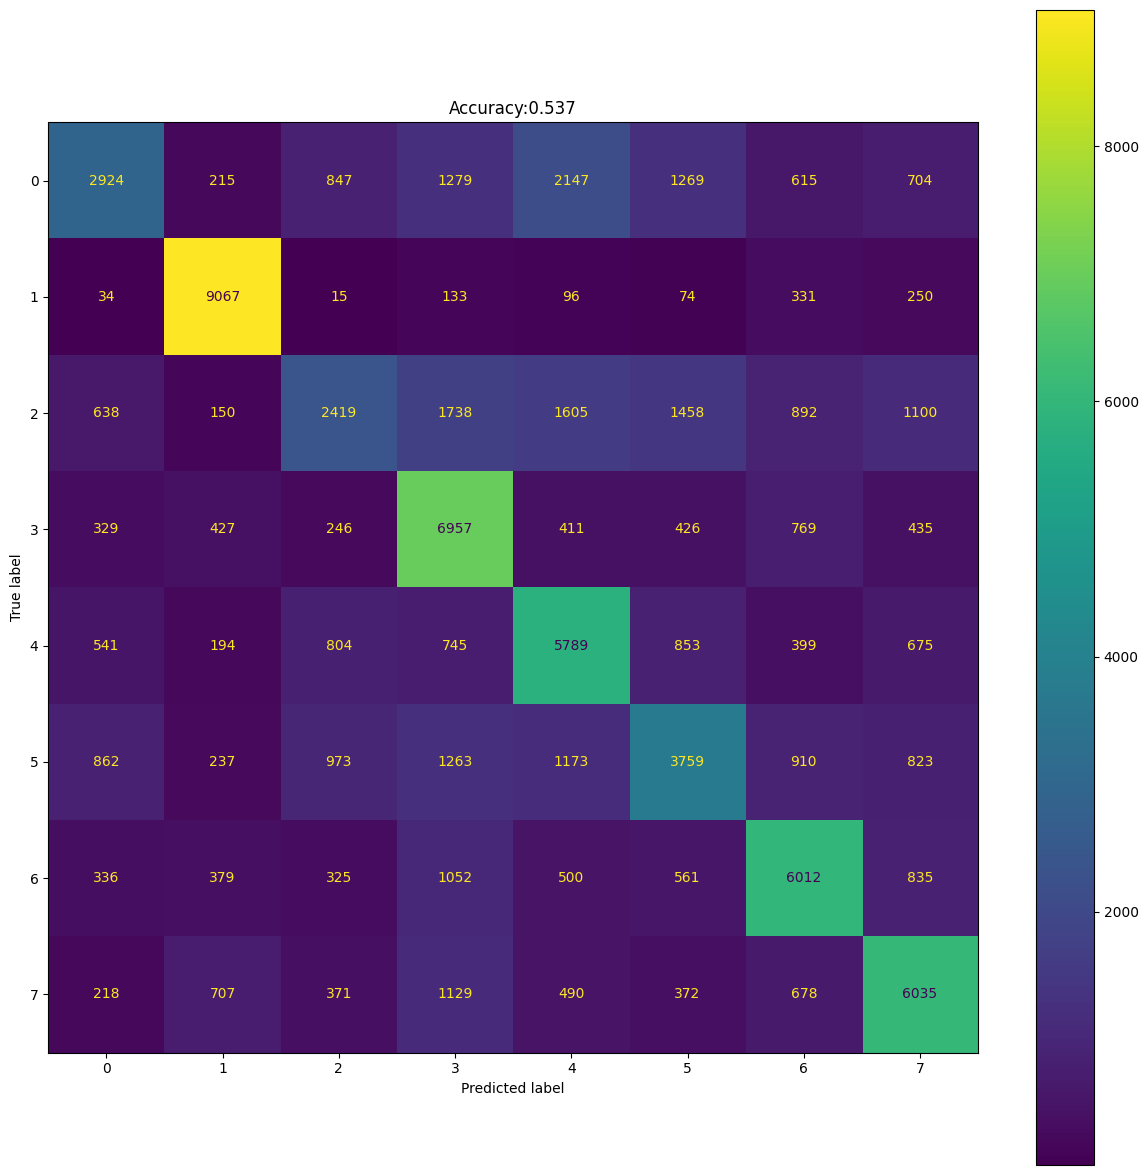

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(i) dataset 

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [20]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 7.1357 - accuracy: 0.1291
test loss, test acc: [7.135682582855225, 0.12911249697208405]


In [21]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[6 6 6 ... 2 5 5]
6
[[  15    0 2935  256    0  944 5849    1]
 [   0    0 8709    0  196 1075   20    0]
 [   0    0 6678    7    0  513 2798    4]
 [   0    0 6429    0    5 2694  871    1]
 [  15    0 2327  892    0 1471 5295    0]
 [   0    0 6061    9    0  412 3518    0]
 [   0    0 6433    0    0  348 3219    0]
 [  28    2 4216   85   22 4605 1037    5]]
              precision    recall  f1-score   support

           0       0.26      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.15      0.67      0.25     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.03      0.04      0.04     10000
           6       0.14      0.32      0.20     10000
           7       0.45      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.13      0.13  

Test Accuracy:0.1291125


Text(0.5, 1.0, 'Accuracy:0.129')

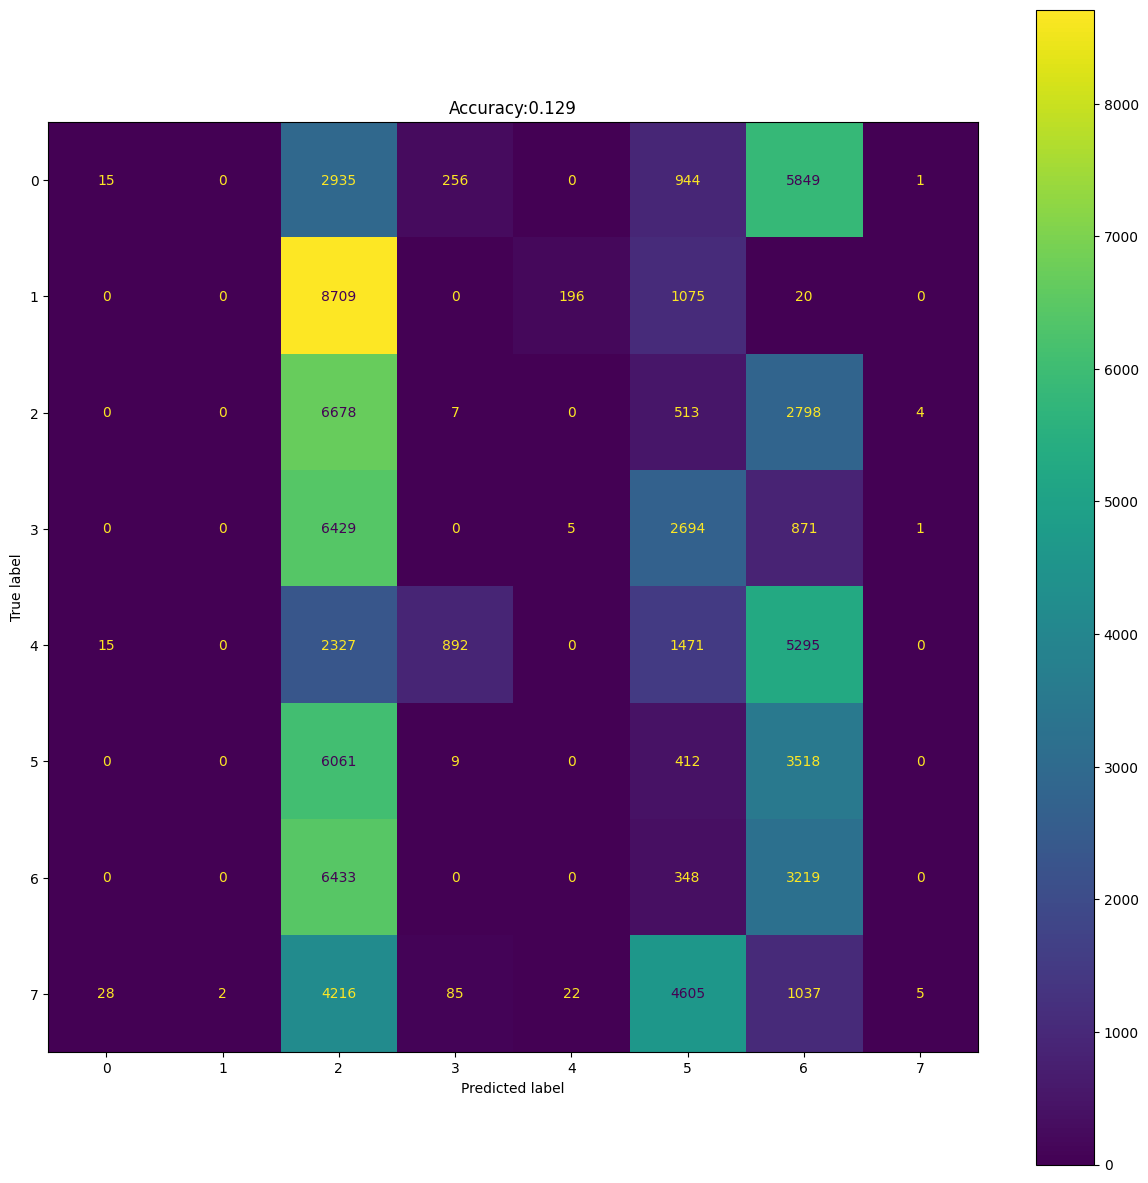

In [22]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [23]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [24]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [25]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.5267 - accuracy: 0.2596
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.3355 - accuracy: 0.5019
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1602 - accuracy: 0.5583
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.0842 - accuracy: 0.5843
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.0405 - accuracy: 0.6019
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.0108 - accuracy: 0.6159
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.9882 - accuracy: 0.6254
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.9705 - accuracy: 0.6333
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.9550 - accuracy: 0.6398
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.94

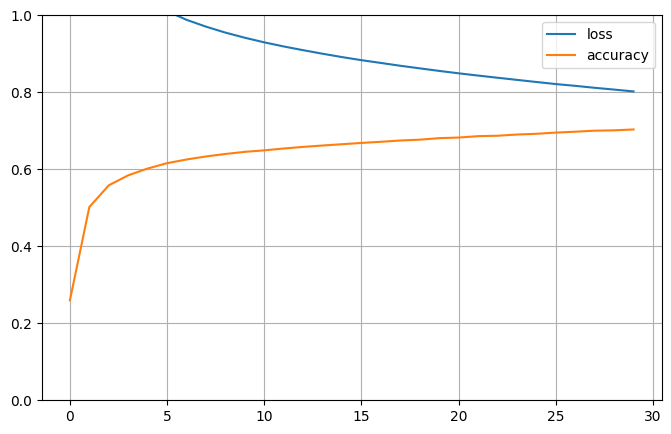

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.7990 - accuracy: 0.7055
test loss, test acc: [0.7990107536315918, 0.7055374979972839]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[4 0 0 ... 2 7 7]
4
[[5744    1  135    0 2361 1396   15  348]
 [   0 9569   27   67    0   38   77  222]
 [ 365   39 4482  264  246 2582 1224  798]
 [   2  223   49 8630    0   23  977   96]
 [1832    0  168    0 7038  558    4  400]
 [ 847   17 1681   88  305 5712  813  537]
 [ 131   80  626  710   35  727 7246  445]
 [ 159  438  596   42  296  246  201 8022]]
              precision    recall  f1-score   support

           0       0.63      0.57      0.60     10000
           1       0.92      0.96      0.94     10000
           2       0.58      0.45      0.50     10000
           3       0.88      0.86      0.87     10000
           4       0.68      0.70      0.69     10000
           5       0.51      0.57      0.54     10000
           6       0.69      0.72      0.70     10000
           7       0.74      0.80      0.77     10000

    accuracy                           0.71     80000
   macro avg       0.70      0.71   

Test Accuracy:0.7055375


Text(0.5, 1.0, 'Accuracy:0.706')

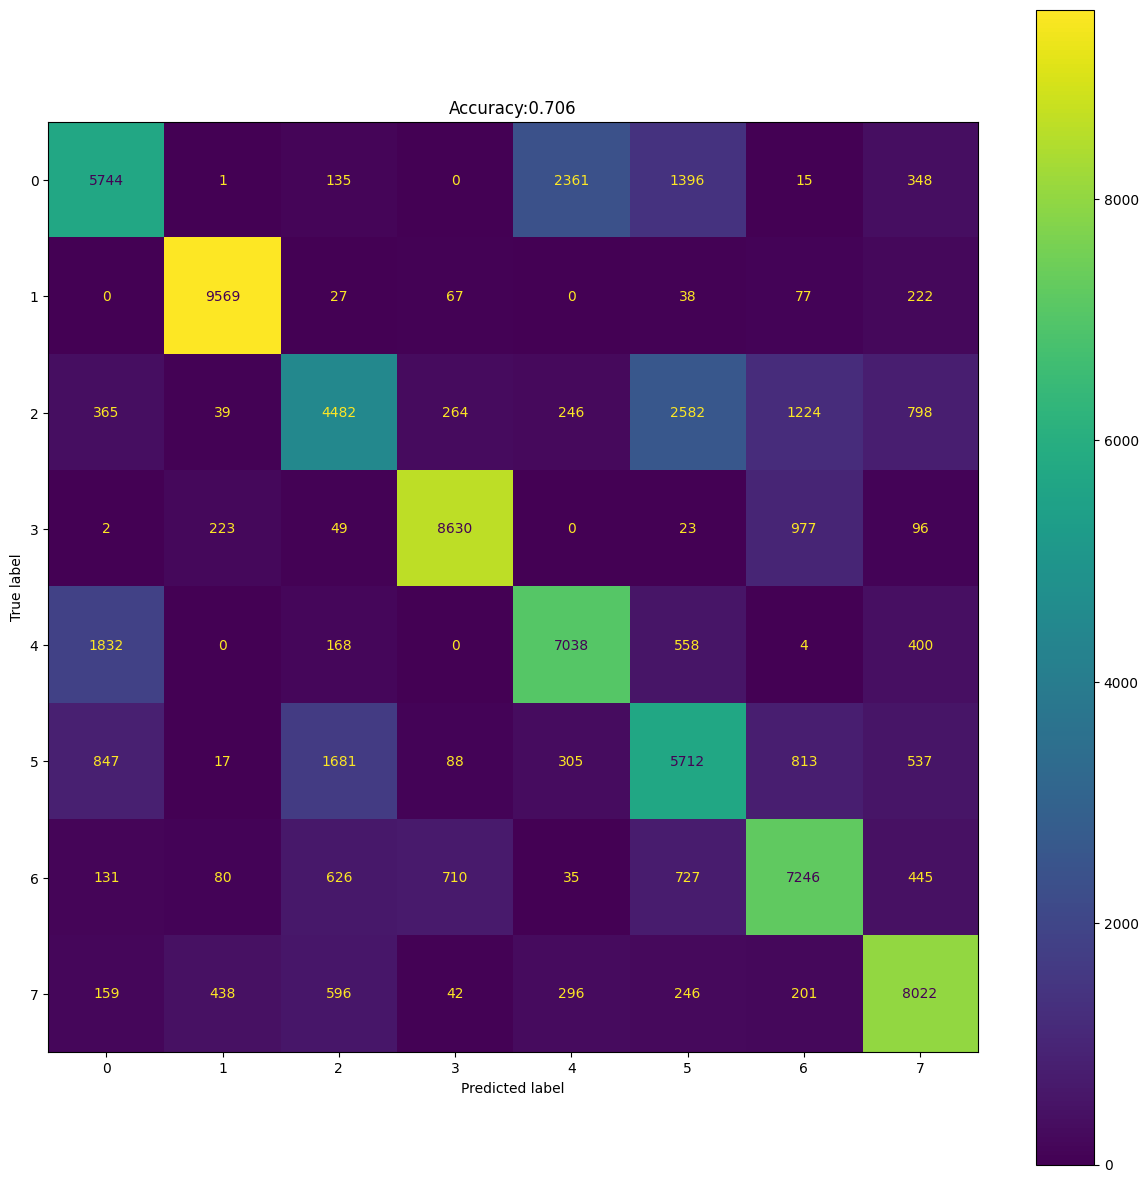

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(i) dataset 

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [31]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 9.8407 - accuracy: 0.1184
test loss, test acc: [9.840728759765625, 0.1184374988079071]


In [32]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 5 5 5]
5
[[   4    0 2195    6    0 6599 1194    2]
 [1169    0 5929    0    0 2794  108    0]
 [   9    1 5767    0    0 2832 1385    6]
 [  83    0 6066    0    0 3738  113    0]
 [   3    8  567   23    0 7436 1954    9]
 [  26    1 6192    1    0 2774 1005    1]
 [ 197    1 6384    0    0 2518  900    0]
 [1221   37 6405    0    2 1980  325   30]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.15      0.58      0.23     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.09      0.28      0.14     10000
           6       0.13      0.09      0.11     10000
           7       0.62      0.00      0.01     10000

    accuracy                           0.12     80000
   macro avg       0.12      0.12  

Test Accuracy:0.1184375


Text(0.5, 1.0, 'Accuracy:0.118')

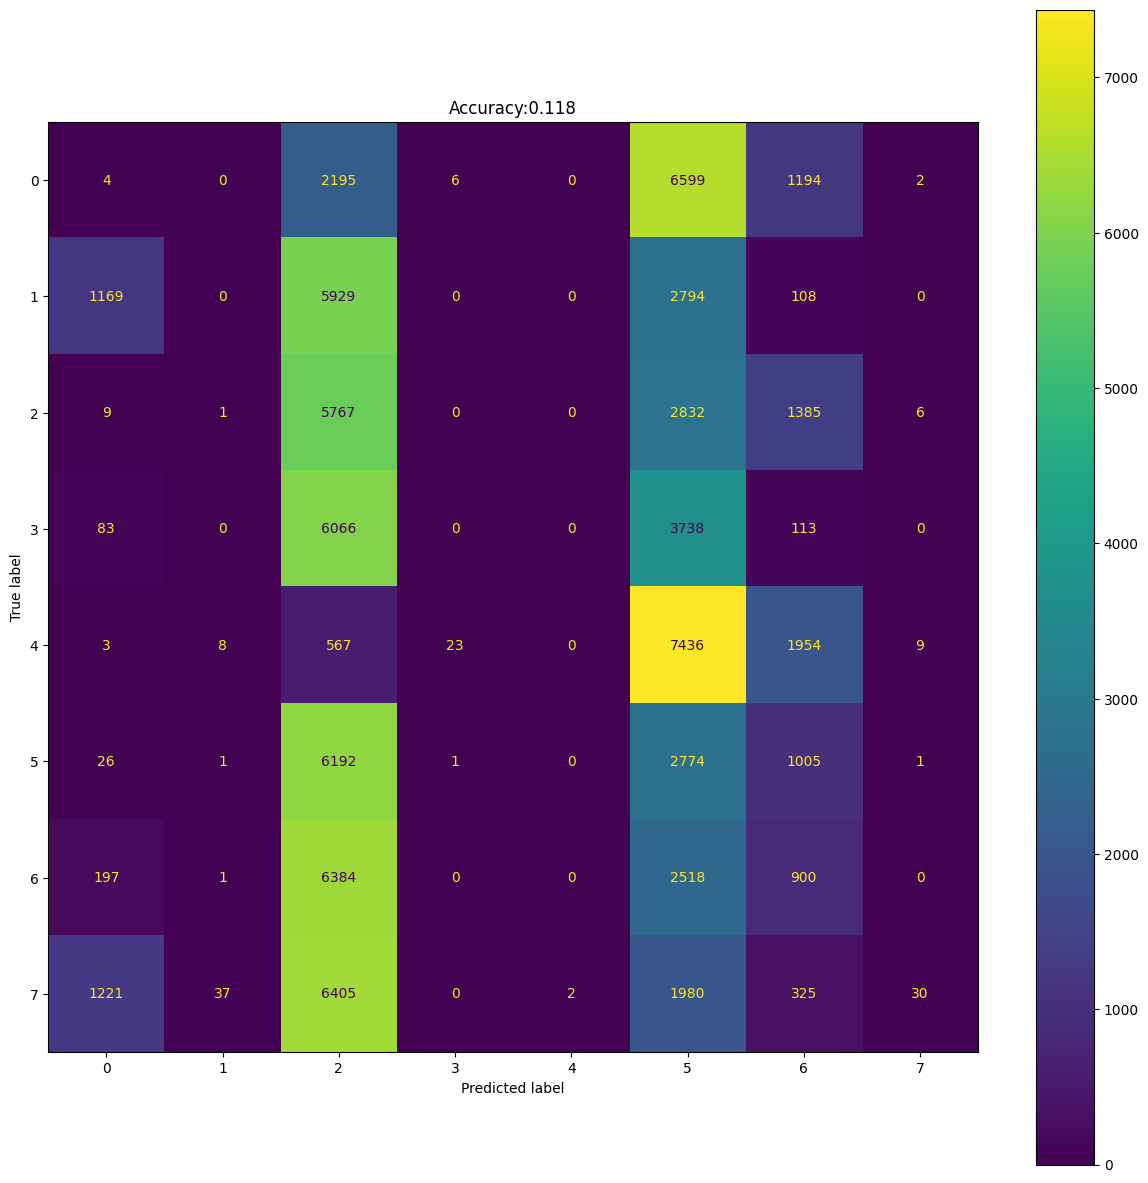

In [33]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [34]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [35]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [36]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.9357 - accuracy: 0.1898
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6450 - accuracy: 0.3854
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4623 - accuracy: 0.4570
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3769 - accuracy: 0.4936
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3216 - accuracy: 0.5169
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2800 - accuracy: 0.5367
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2462 - accuracy: 0.5507
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2171 - accuracy: 0.5639
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.1922 - accuracy: 0.5749
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

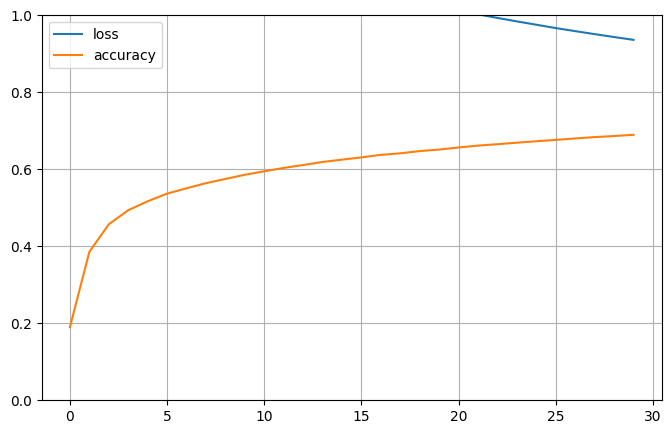

In [37]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.9389 - accuracy: 0.6842
test loss, test acc: [0.9389474391937256, 0.6841874718666077]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 4 0 ... 4 0 2]
0
[[7527    6  474    8 1050  458   88  389]
 [  51 8764   66  315    3   60  532  209]
 [ 973   30 5284  343  171 1027 1718  454]
 [  24  361  119 8546    1   84  785   80]
 [3355    0  195    0 6134   60   34  222]
 [1507   94 1813  324   98 3718 1618  828]
 [ 195  315  793  777   25  403 7180  312]
 [ 643  158  661   29  601  112  214 7582]]
              precision    recall  f1-score   support

           0       0.53      0.75      0.62     10000
           1       0.90      0.88      0.89     10000
           2       0.56      0.53      0.54     10000
           3       0.83      0.85      0.84     10000
           4       0.76      0.61      0.68     10000
           5       0.63      0.37      0.47     10000
           6       0.59      0.72      0.65     10000
           7       0.75      0.76      0.76     10000

    accuracy                           0.68     80000
   macro avg       0.69      0.68  

Test Accuracy:0.6841875


Text(0.5, 1.0, 'Accuracy:0.684')

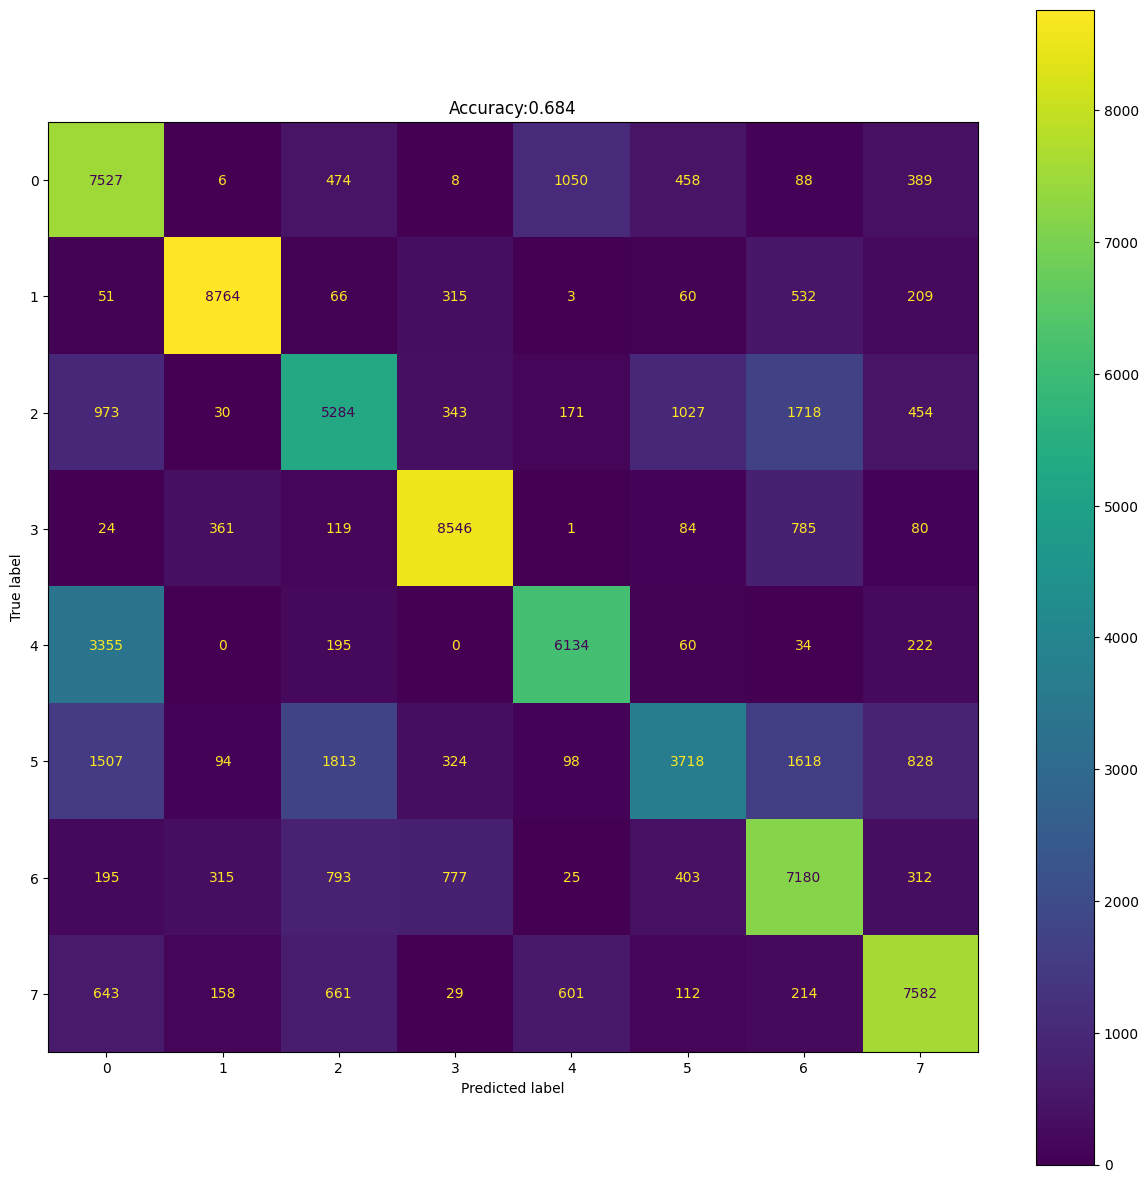

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(i) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 4.7158 - accuracy: 0.1120
test loss, test acc: [4.7158203125, 0.11202500015497208]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 4 ... 4 5 4]
5
[[   0    1 2834  159 1330 5418  118  140]
 [ 352  208 2974 2279 1418 1356  940  473]
 [  35    8 1890  461 2630 4374  178  424]
 [   1    4 1259  120 2308 4827   10 1471]
 [   2   15 1135  128 1068 7391  204   57]
 [   5    4 2125  411 2122 4975  208  150]
 [  21    1 1483  376 1073 5427  209 1410]
 [   1   80 1980   42 1728 5314  363  492]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.65      0.02      0.04     10000
           2       0.12      0.19      0.15     10000
           3       0.03      0.01      0.02     10000
           4       0.08      0.11      0.09     10000
           5       0.13      0.50      0.20     10000
           6       0.09      0.02      0.03     10000
           7       0.11      0.05      0.07     10000

    accuracy                           0.11     80000
   macro avg       0.15      0.11  

Test Accuracy:0.112025


Text(0.5, 1.0, 'Accuracy:0.112')

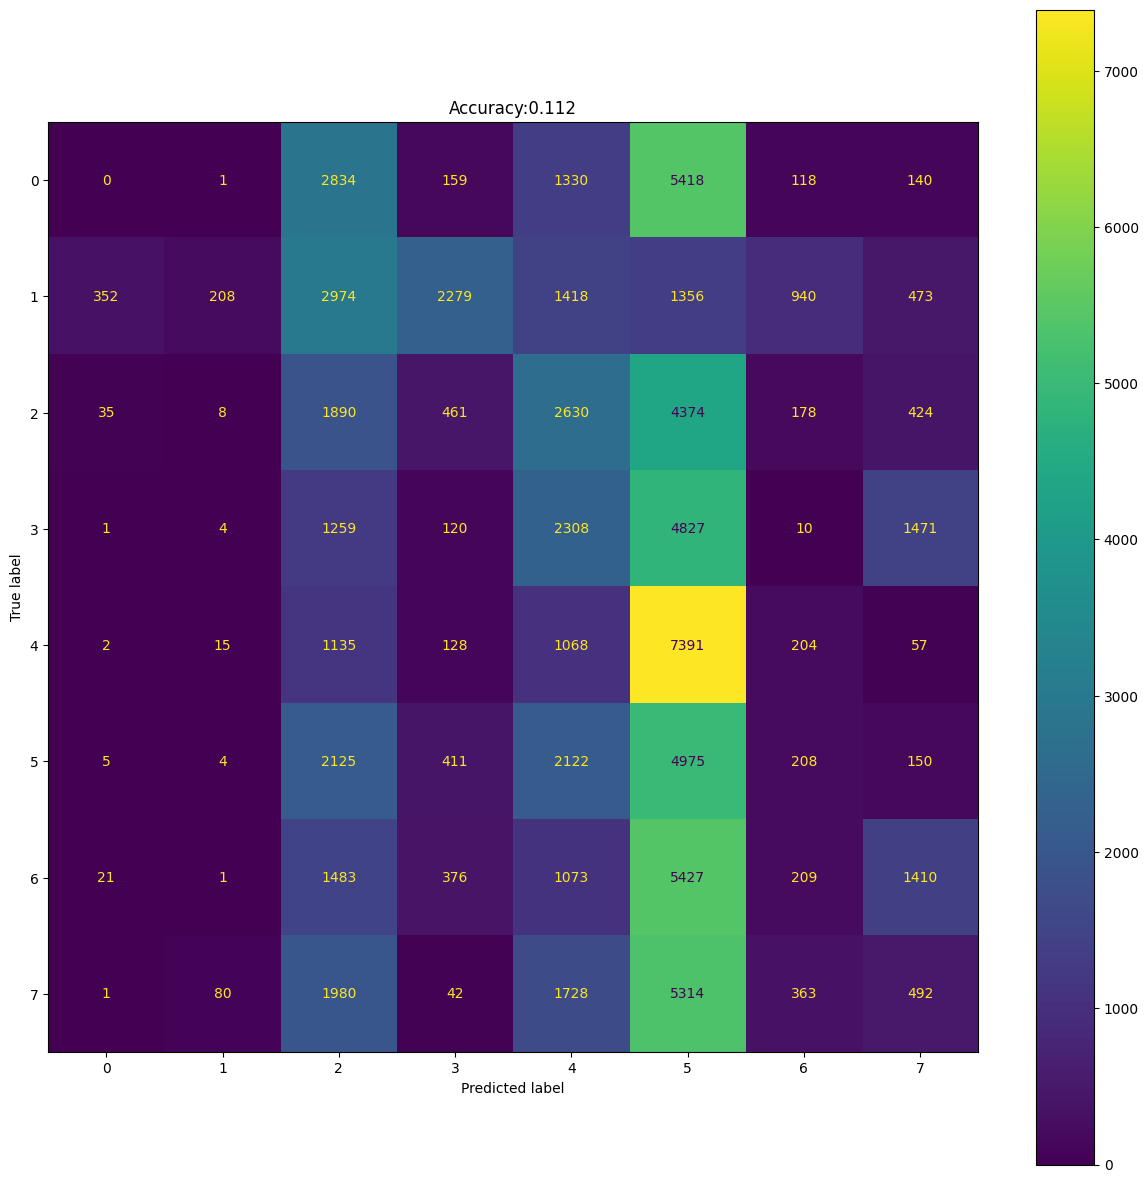

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8593 - accuracy: 0.1613
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7948 - accuracy: 0.3371
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4995 - accuracy: 0.4646
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4023 - accuracy: 0.5092
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3546 - accuracy: 0.5275
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3237 - accuracy: 0.5373
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3008 - accuracy: 0.5431
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2819 - accuracy: 0.5504
Epoch 9/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.2656 - accuracy: 0.5548
Epoch 10/30
2500/2500 [==============================] - 11s 5ms/step - l

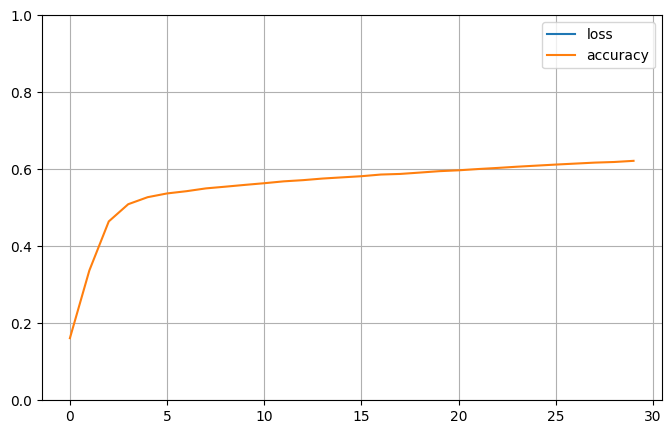

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.0847 - accuracy: 0.6199
test loss, test acc: [1.0847398042678833, 0.6199125051498413]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 4 5]
0
[[5519   17 1059  806 1088  865  420  226]
 [   2 9175  243   51   92   37  218  182]
 [ 660  476 4980  464 1347  716 1002  355]
 [ 530   47  351 7655  373  173  580  291]
 [1005  126 1716  330 5234  467  644  478]
 [1505  231 2751  578 1572 2400  553  410]
 [ 361  289 1341  469  655  179 6163  543]
 [  96  270  233  326  270  119  219 8467]]
              precision    recall  f1-score   support

           0       0.57      0.55      0.56     10000
           1       0.86      0.92      0.89     10000
           2       0.39      0.50      0.44     10000
           3       0.72      0.77      0.74     10000
           4       0.49      0.52      0.51     10000
           5       0.48      0.24      0.32     10000
           6       0.63      0.62      0.62     10000
           7       0.77      0.85      0.81     10000

    accuracy                           0.62     80000
   macro avg       0.62      0.62  

Test Accuracy:0.6199125


Text(0.5, 1.0, 'Accuracy:0.620')

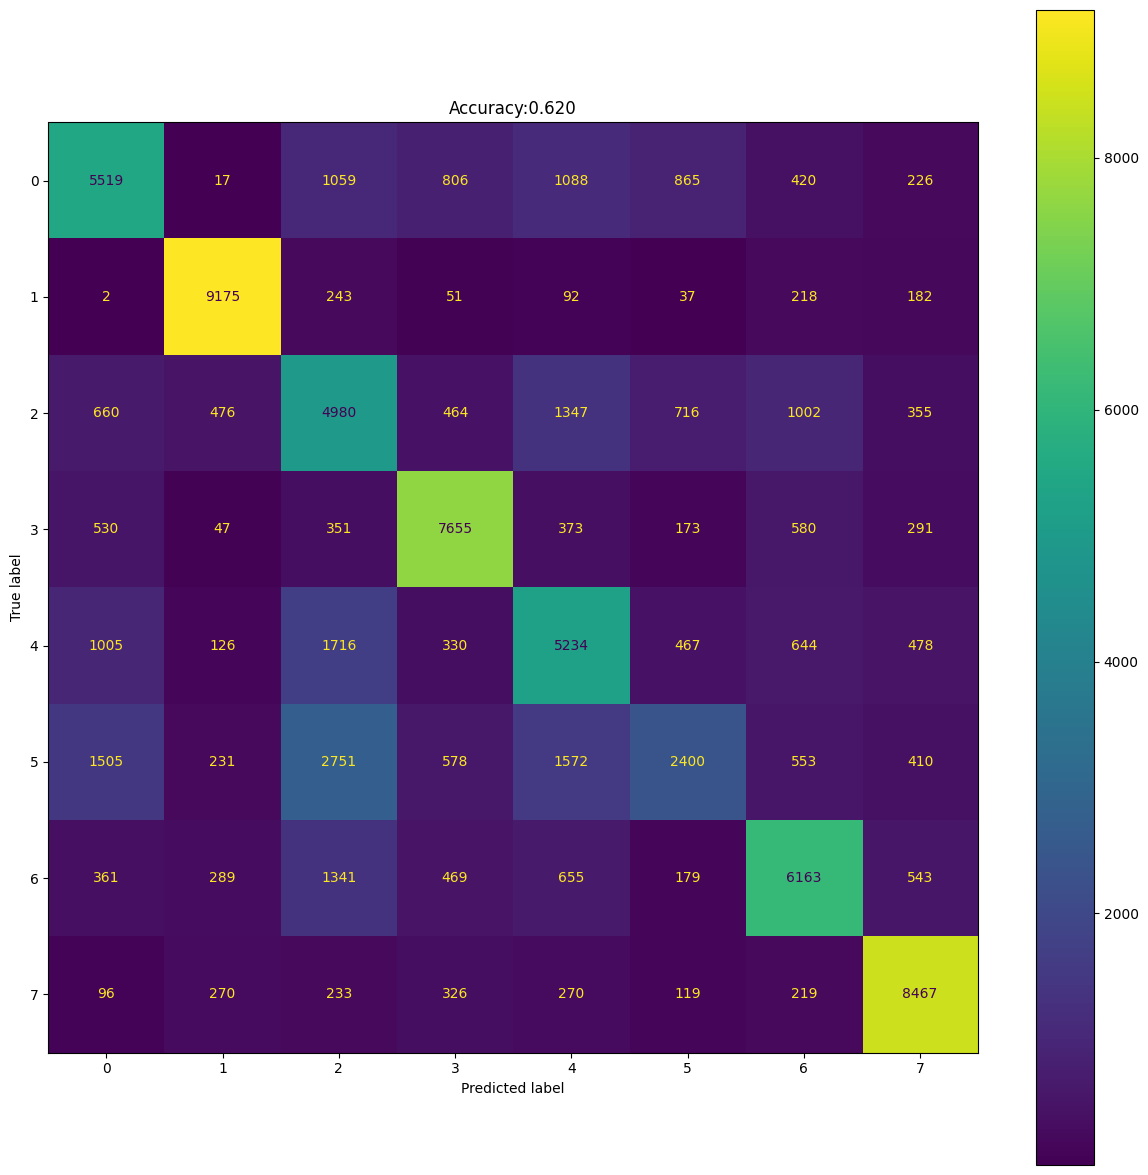

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-25(i) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 6.0350 - accuracy: 0.1258
test loss, test acc: [6.035015106201172, 0.125837504863739]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[5 5 0 ... 5 5 5]
5
[[1745    0  186    7    0 8059    3    0]
 [ 109    0 2242  456    0 6138 1045   10]
 [1513    0  183    1    0 8299    4    0]
 [4893    0    7    1    0 5099    0    0]
 [1731    0  120    1    0 8141    7    0]
 [1788    0  256   14    0 7936    6    0]
 [2292    0  137    5    0 7555    5    6]
 [ 367    7  310    0   61 8614  444  197]]
              precision    recall  f1-score   support

           0       0.12      0.17      0.14     10000
           1       0.00      0.00      0.00     10000
           2       0.05      0.02      0.03     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.79      0.23     10000
           6       0.00      0.00      0.00     10000
           7       0.92      0.02      0.04     10000

    accuracy                           0.13     80000
   macro avg       0.15      0.13   

Test Accuracy:0.1258375


Text(0.5, 1.0, 'Accuracy:0.126')

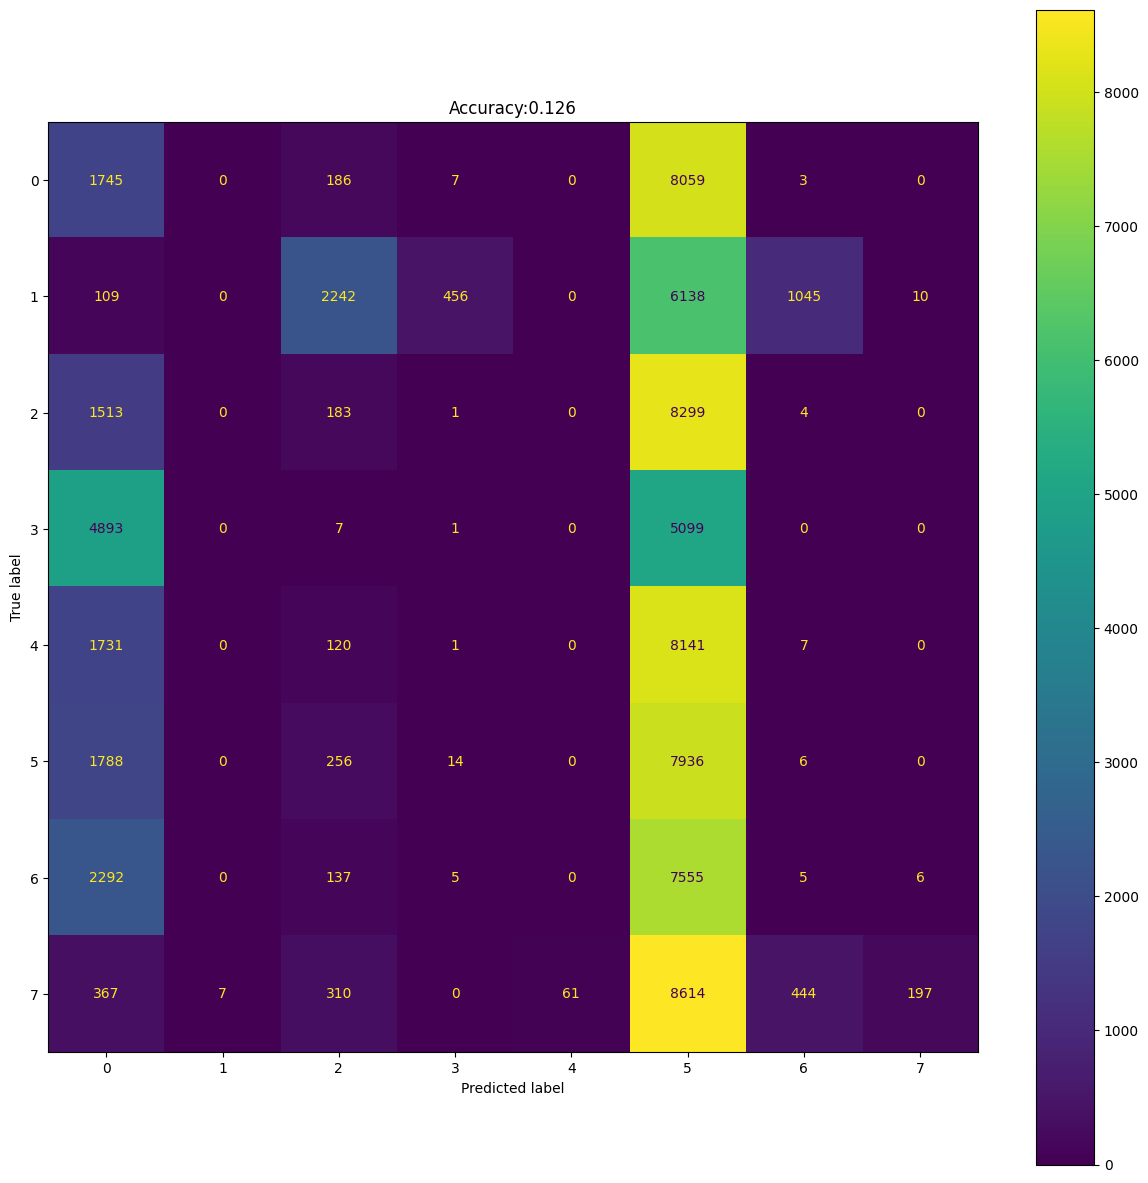

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.5243 - accuracy: 0.2059
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.6621 - accuracy: 0.3732
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4764 - accuracy: 0.4441
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3943 - accuracy: 0.4774
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3426 - accuracy: 0.4978
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3047 - accuracy: 0.5151
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2752 - accuracy: 0.5291
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2498 - accuracy: 0.5408
Epoch 9/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.2282 - accuracy: 0.5515
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - lo

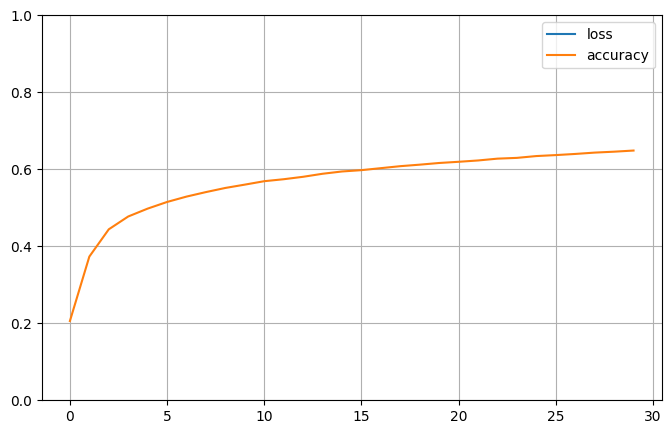

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.0038 - accuracy: 0.6513
test loss, test acc: [1.0038281679153442, 0.6513375043869019]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 0 0 ... 7 6 6]
4
[[5399  101  648  802 1315 1122  498  115]
 [   8 9517   18    4   42   25  148  238]
 [1149  198 3507  906 1551 1136 1013  540]
 [ 551    7  352 7732  420  187  701   50]
 [ 963   82  475  525 6164 1108  430  253]
 [1709  221  940  563 2314 3655  417  181]
 [ 237   93  394  665  451  148 7410  602]
 [   4  276  148   41  320   69  419 8723]]
              precision    recall  f1-score   support

           0       0.54      0.54      0.54     10000
           1       0.91      0.95      0.93     10000
           2       0.54      0.35      0.43     10000
           3       0.69      0.77      0.73     10000
           4       0.49      0.62      0.55     10000
           5       0.49      0.37      0.42     10000
           6       0.67      0.74      0.70     10000
           7       0.82      0.87      0.84     10000

    accuracy                           0.65     80000
   macro avg       0.64      0.65  

Test Accuracy:0.6513375


Text(0.5, 1.0, 'Accuracy:0.651')

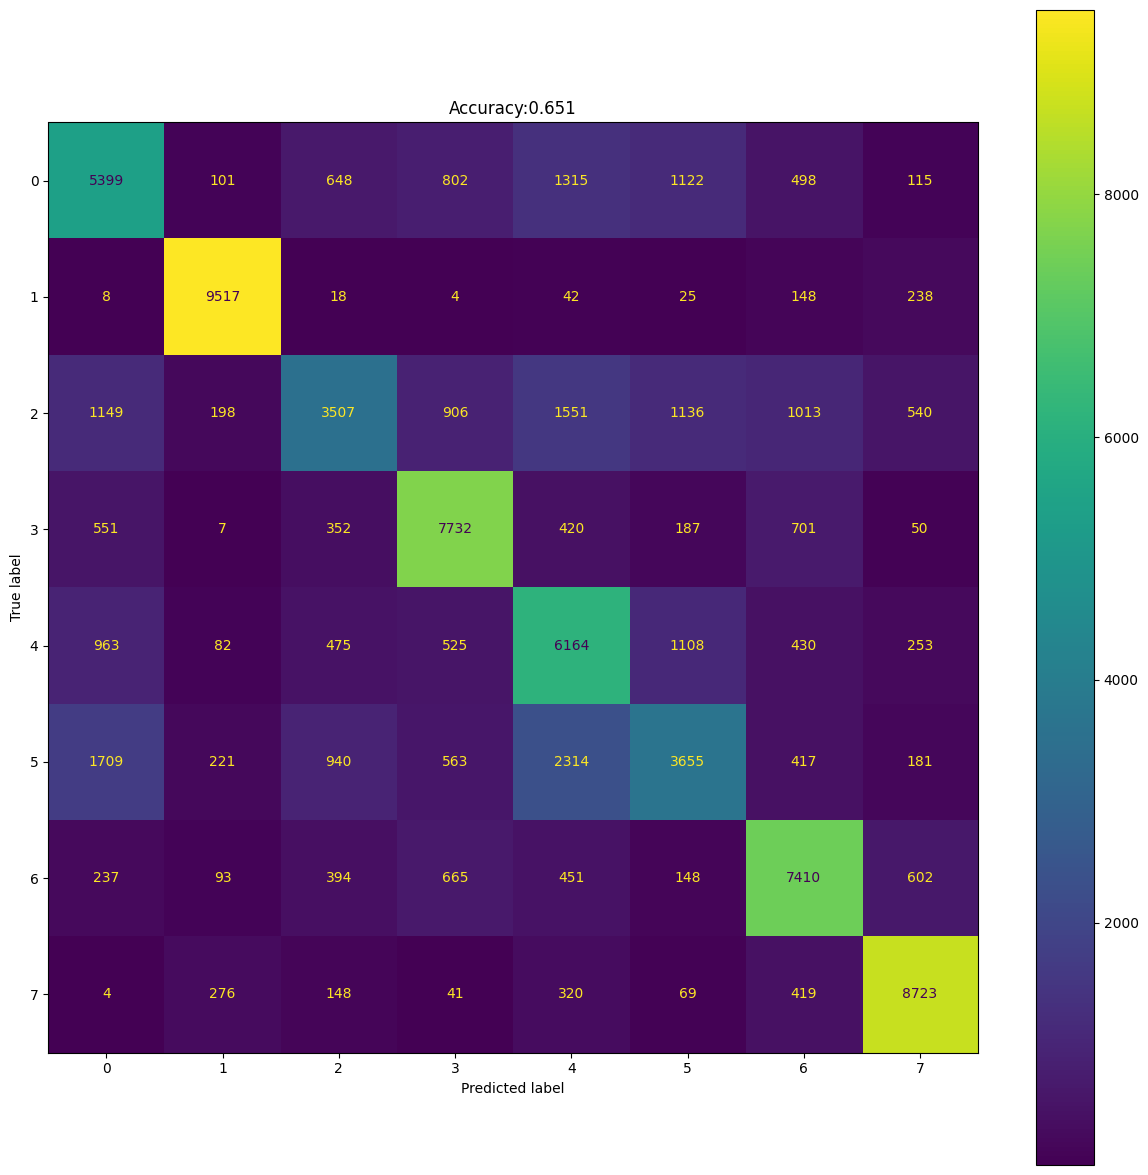

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-25(i) dataset 

In [59]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [60]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 5.3410 - accuracy: 0.1258
test loss, test acc: [5.341007232666016, 0.12581250071525574]


In [62]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 0 0 5]
0
[[3985    0  130   21    0 5861    2    1]
 [1338  184 4236 1038  165 1441 1594    4]
 [4140    3  212  119    0 5512    8    6]
 [2879    2   33  126    0 6673    0  287]
 [4098    0  207   18    0 5671    5    1]
 [4173    2  222   69    0 5521    3   10]
 [4831    0  183   55    0 4861   13   57]
 [4735  458 2064  189    1 2275  254   24]]
              precision    recall  f1-score   support

           0       0.13      0.40      0.20     10000
           1       0.28      0.02      0.03     10000
           2       0.03      0.02      0.02     10000
           3       0.08      0.01      0.02     10000
           4       0.00      0.00      0.00     10000
           5       0.15      0.55      0.23     10000
           6       0.01      0.00      0.00     10000
           7       0.06      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.09      0.13  

Test Accuracy:0.1258125


Text(0.5, 1.0, 'Accuracy:0.126')

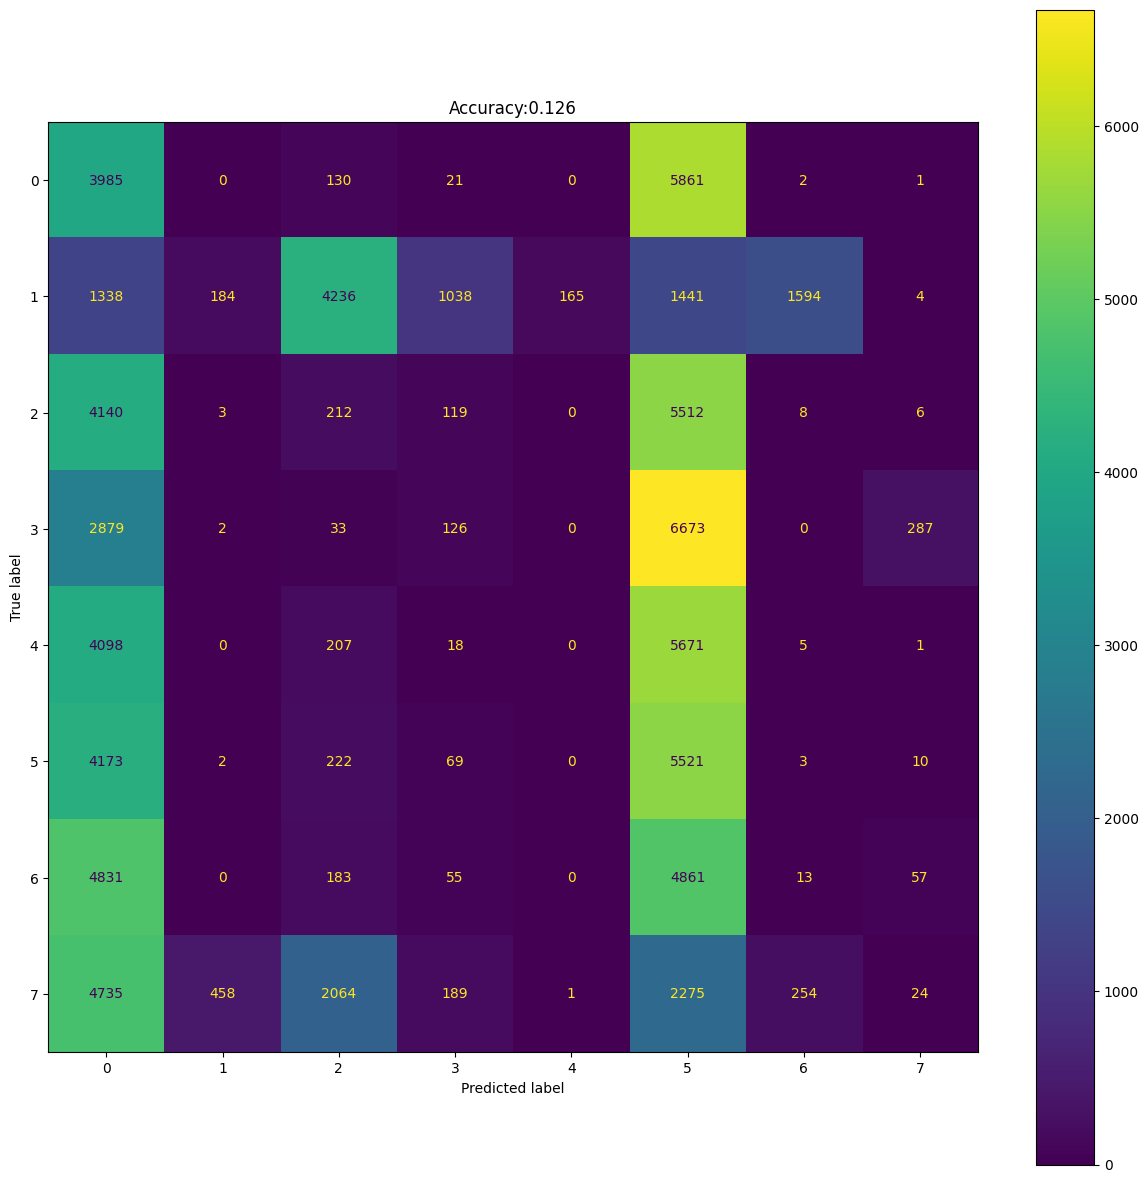

In [63]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [64]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [65]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [66]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.5592 - accuracy: 0.1918
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7709 - accuracy: 0.3293
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5559 - accuracy: 0.3876
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4524 - accuracy: 0.4318
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3938 - accuracy: 0.4631
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3552 - accuracy: 0.4844
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3267 - accuracy: 0.4999
Epoch 8/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.3043 - accuracy: 0.5098
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2855 - accuracy: 0.5190
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - los

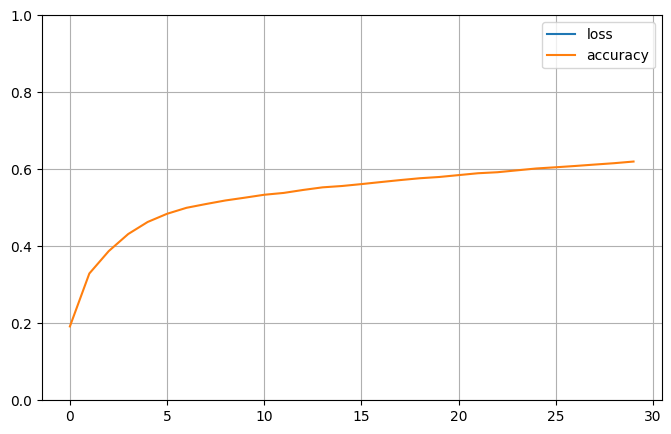

In [67]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [68]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.0788 - accuracy: 0.6231
test loss, test acc: [1.0788242816925049, 0.6230999827384949]


In [69]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[6 0 0 ... 7 6 7]
6
[[5461    1  700  692 1096 1078  928   44]
 [   6 9632   24    3    4   12   22  297]
 [ 979   14 3848 1031  866 1613 1169  480]
 [ 619    1  376 7630  264  323  624  163]
 [1724    4 1170  631 4380 1134  711  246]
 [1546    5 1795 1132  896 3300 1033  293]
 [ 560   18  541  676  287  439 7182  297]
 [  42  647  310  120  105   51  310 8415]]
              precision    recall  f1-score   support

           0       0.50      0.55      0.52     10000
           1       0.93      0.96      0.95     10000
           2       0.44      0.38      0.41     10000
           3       0.64      0.76      0.70     10000
           4       0.55      0.44      0.49     10000
           5       0.42      0.33      0.37     10000
           6       0.60      0.72      0.65     10000
           7       0.82      0.84      0.83     10000

    accuracy                           0.62     80000
   macro avg       0.61      0.62  

Test Accuracy:0.6231


Text(0.5, 1.0, 'Accuracy:0.623')

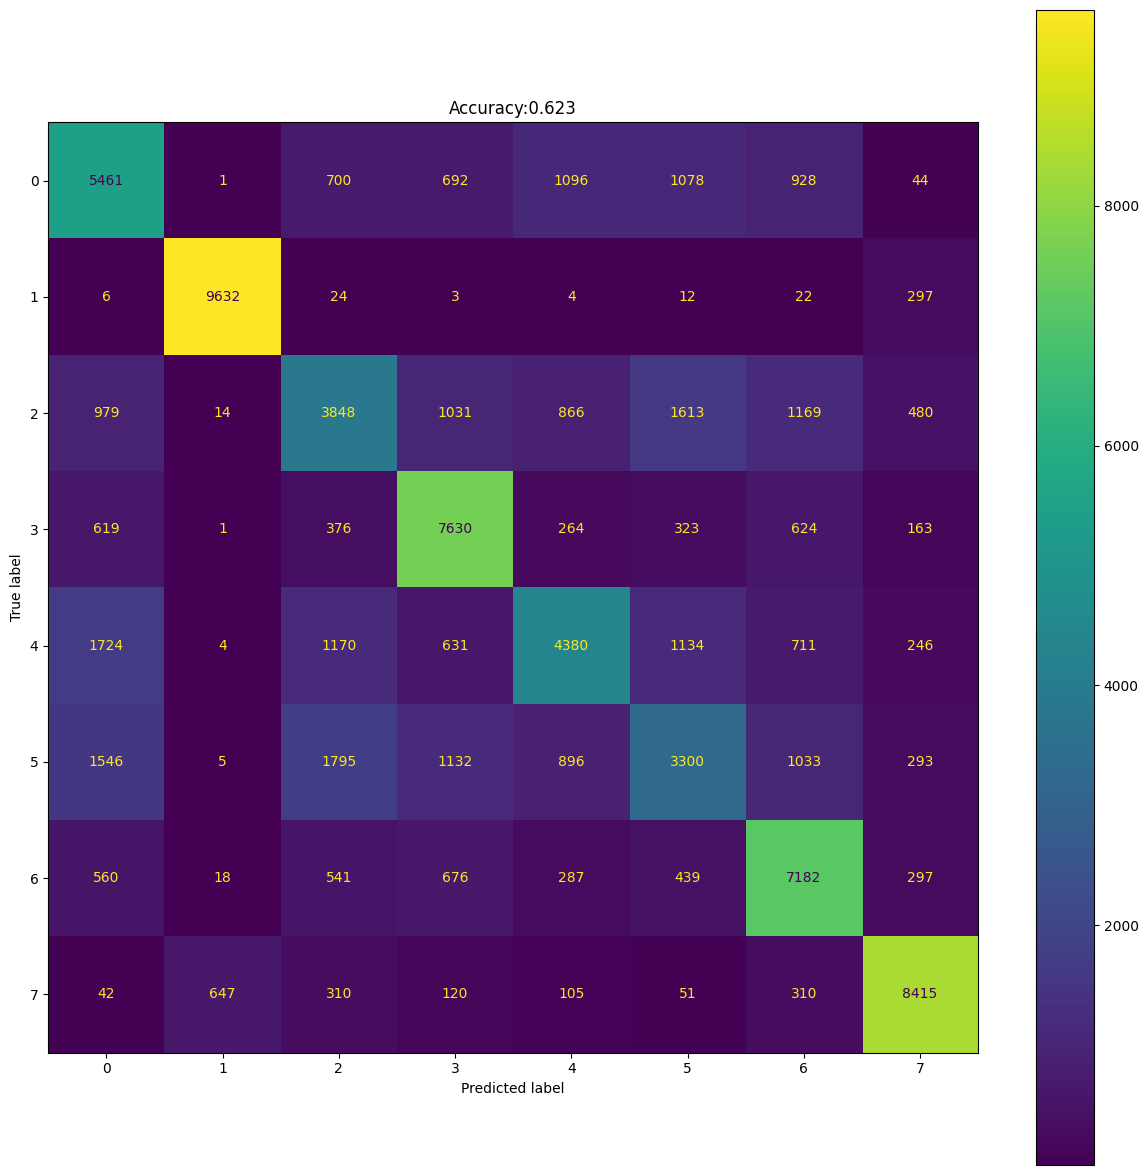

In [70]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')